In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, roc_auc_score

import warnings
warnings.simplefilter('ignore')

In [2]:
train_data = pd.read_csv('../../Data/preprocessed2-train-bank-data.csv', sep=';')
X_train, y_train = train_data.drop('y', axis=1), train_data['y']

In [3]:
model_dict = {}
names = ['DTC','LOGR','MLPC','RFC','SVC']

# loading model prototypes
for i, model_path in enumerate(['decision_tree_classifier','logistic_regression','MLP_classifier','random_forest_classifier','SVC']):
    file = open(f'C:/Users/frane/kaggleproject/Models/Serialized_models/{model_path}_prototype.pickle', 'rb')
    model = pickle.load(file)
    file.close()
    model_dict[names[i]] = model

In [4]:
"""Cross validation using KFold"""

results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=31)

for model in model_dict.keys():
    aucs = np.array([])
    aucs_seen = np.array([])
    accuracies = np.array([])
    accuracies_seen = np.array([])

    for train_idx, test_idx in kf.split(X_train, y_train):
        X_train_train = X_train.iloc[train_idx]
        y_train_train = y_train.iloc[train_idx]
        X_train_test = X_train.iloc[test_idx]
        y_train_test = y_train.iloc[test_idx]
        
        model_dict[model].fit(X_train_train, y_train_train)

        accuracies = np.append(accuracies, accuracy_score(y_train_test, model_dict[model].predict(X_train_test)))
        accuracies_seen = np.append(accuracies_seen, accuracy_score(y_train_train, model_dict[model].predict(X_train_train)))

        if model == 'SVC':
            aucs = np.append(aucs, roc_auc_score(y_train_test, model_dict[model]._predict_proba_lr(X_train_test)[:,1]))
            aucs_seen = np.append(aucs_seen, roc_auc_score(y_train_train, model_dict[model]._predict_proba_lr(X_train_train)[:,1]))
        else:
            aucs = np.append(aucs, roc_auc_score(y_train_test, model_dict[model].predict_proba(X_train_test)[:,1]))
            aucs_seen = np.append(aucs_seen, roc_auc_score(y_train_train, model_dict[model].predict_proba(X_train_train)[:,1]))

    results[model] = (aucs.mean(), aucs_seen.mean(), accuracies.mean(), accuracies_seen.mean(), aucs.var(), accuracies.var())

# Results of cross validation

In [5]:
results_df = pd.DataFrame(results, index=['avg_roc_auc','avg_seen_roc_auc','avg_accuracy','avg_seen_accuracy','roc_auc_var','accuracy_var'])
results_df

,DTC,LOGR,MLPC,RFC,SVC
avg_roc_auc,0.780299,0.775719,0.783046,0.795506,0.746249
avg_seen_roc_auc,0.792656,0.779792,0.802824,0.832813,0.747533
avg_accuracy,0.844413,0.775732,0.898674,0.851860,0.718361
avg_seen_accuracy,0.844579,0.776007,0.900504,0.855489,0.718361
roc_auc_var,0.000081,0.000093,0.000052,0.000030,0.000143
accuracy_var,0.000083,0.000014,0.000007,0.000004,0.000024


<AxesSubplot:title={'center':'Variance of metrics of models in KFold cross validation (measure of overfitting)'}>

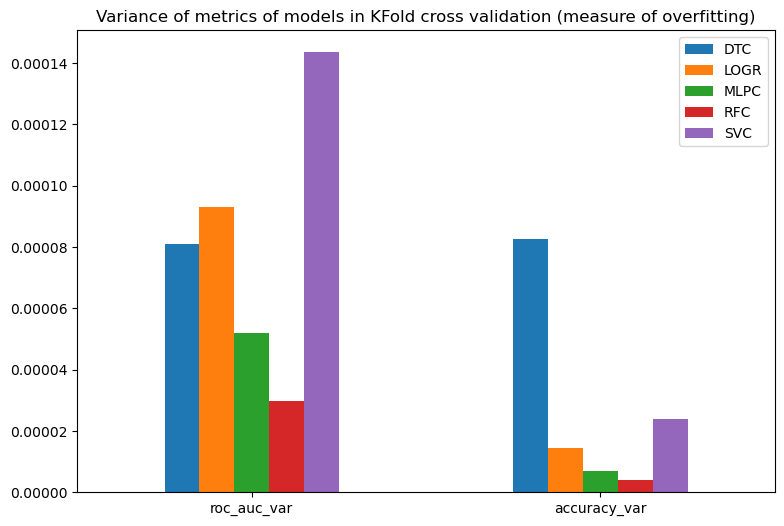

In [6]:
results_df.loc[['roc_auc_var','accuracy_var']].plot(kind='bar', figsize=(9,6), rot=0, 
                                                    title='Variance of metrics of models in KFold cross validation (measure of overfitting)')

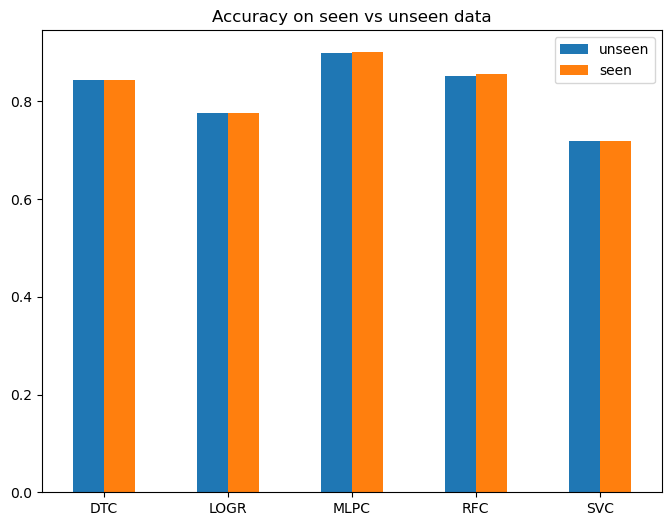

In [7]:
ax = results_df.loc[['avg_accuracy','avg_seen_accuracy']].transpose().plot(kind='bar', figsize=(8, 6), rot=0,
                                                                      title='Accuracy on seen vs unseen data')
ax.legend(labels=['unseen','seen'])                                                                      

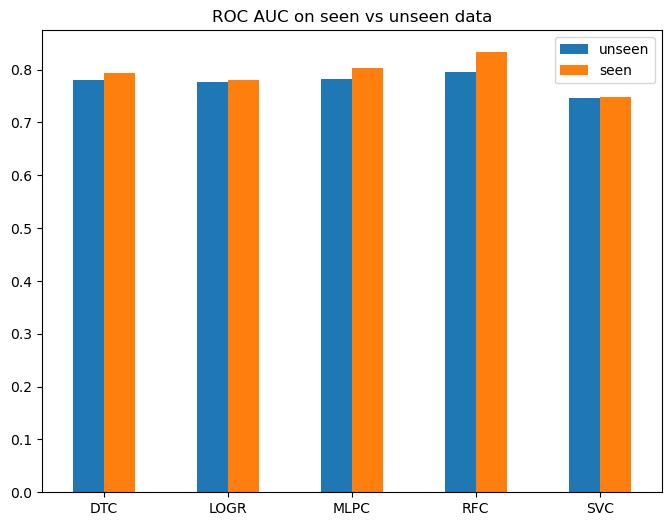

In [8]:
ax = results_df.loc[['avg_roc_auc','avg_seen_roc_auc']].transpose().plot(kind='bar', figsize=(8, 6), rot=0,
                                                                      title='ROC AUC on seen vs unseen data')
ax.legend(labels=['unseen','seen'])   

<AxesSubplot:title={'center':'Average metrics of models in KFold cross validation'}>

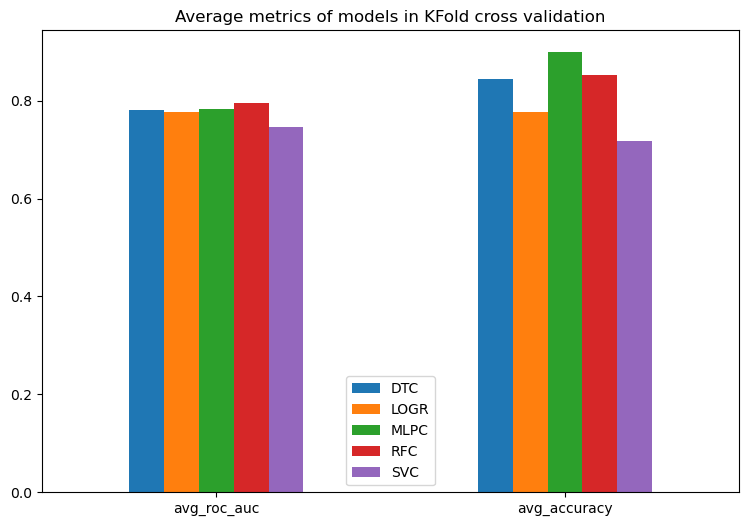

In [9]:
results_df.loc[['avg_roc_auc','avg_accuracy']].plot(kind='bar', figsize=(9,6), rot=0, 
                                                    title='Average metrics of models in KFold cross validation')